![pydatalogo](https://user-images.githubusercontent.com/7065401/46249227-f76b1d80-c3fb-11e8-931e-8a9adc12bd4e.png)

<div style="color: #444; text-align: center;">
    <b>Córdoba 2018</b>
    <br>
    <span>Matías Caputti</span>
</div>

---

# Fruit recognition

Import necessary libraries:

In [3]:
import os
import random
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import preprocessing

%matplotlib inline

In [59]:
class_names = ['APPLE', 'BANANA', 'PEAR']

In [60]:
width = 96
height = 96

Take a look at the folders to see if images were saved correctly.

Now let's load again the images:

In [61]:
import os
import random
from glob import glob
from keras import preprocessing

In [66]:
def load_images(base_path):
    images = []
    path = os.path.join(base_path, '*.png')
    for image_path in glob(path):
        image = preprocessing.image.load_img(image_path,
                                             target_size=(width, height))
        x = preprocessing.image.img_to_array(image)

        images.append(x)
    return images

In [67]:
apples = load_images('./data/apples')
bananas = load_images('./data/bananas')
pears = load_images('./data/pears')

5 random APPLE images:

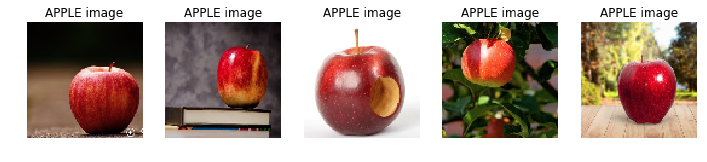

In [68]:
plt.figure(figsize=(12,8))

for i in range(5):
    plt.subplot(1, 5, i+1)
    image = preprocessing.image.array_to_img(random.choice(apples))
    plt.imshow(image)
    
    plt.axis('off')
    plt.title('{} image'.format(class_names[0]))

# show the plot
plt.show()

5 random BANANA images:

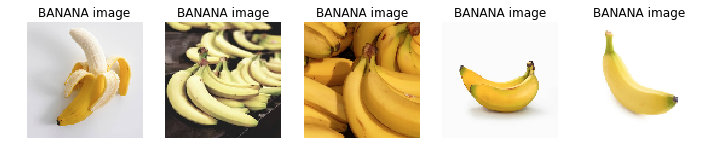

In [69]:
plt.figure(figsize=(12,8))

for i in range(5):
    plt.subplot(1, 5, i+1)
    image = preprocessing.image.array_to_img(random.choice(bananas))
    plt.imshow(image)
    
    plt.axis('off')
    plt.title('{} image'.format(class_names[1]))

# show the plot
plt.show()

5 random PEAR images:

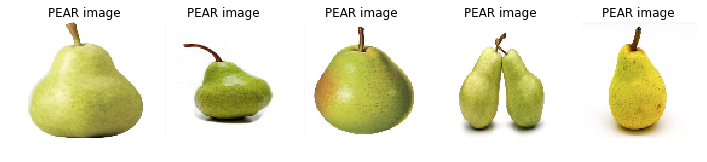

In [70]:
plt.figure(figsize=(12,8))

for i in range(5):
    plt.subplot(1, 5, i+1)
    image = preprocessing.image.array_to_img(random.choice(pears))
    plt.imshow(image)
    
    plt.axis('off')
    plt.title('{} image'.format(class_names[2]))

# show the plot
plt.show()

### Prepare images as tensors

In [71]:
X_1 = np.array(apples)
X_2 = np.array(bananas)
X_3 = np.array(pears)

print(X_1.shape)
print(X_2.shape)
print(X_3.shape)

(20, 96, 96, 3)
(20, 96, 96, 3)
(20, 96, 96, 3)


We'll now build one big array containing ALL the images: 

In [72]:
X = np.concatenate((X_1, X_2, X_3), axis=0)

Remember our color pixels, the ones that went from 0-255? We'll rescale them to be between 0 and 1. This will make the model work better.

In [73]:
X = X / 255.

X.shape

(60, 96, 96, 3)

We need to create a `y_train`, so we'll use `0` to indicate `TYPE_1`, and `1` to indicate `TYPE_2`.

In [74]:
from keras.utils import to_categorical

y_1 = [0 for item in enumerate(X_1)]
y_2 = [1 for item in enumerate(X_2)]
y_3 = [2 for item in enumerate(X_3)]

y = np.concatenate((y_1, y_2, y_3), axis=0)

y = to_categorical(y, num_classes=len(class_names))

print(y.shape)

(60, 3)


## Train/Test partitions

<img width="350" alt="" src="https://user-images.githubusercontent.com/7065401/46251671-37e48e80-c430-11e8-81f9-0cbfeef3df41.png">


Now we can use the _train_test_split_ function in order to make the split.

The _test_size=0.2_ inside the function indicates the percentage of the data that should be held over for testing. It’s usually around 80/20 or 70/30.

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)

(54, 96, 96, 3)
(6, 96, 96, 3)


## Convolutional network configuration

<img width="645" alt="" src="https://user-images.githubusercontent.com/7065401/46251776-8f382e00-c433-11e8-90be-4673bfcb36c1.png">

Let's create a deep network which will learn our emotions and then will try to predict them.


### Feature extraction using convolution layer

Convolution is one of the main building blocks of a CNN. The term convolution refers to the mathematical combination of two functions to produce a third function. It merges two sets of information.

In the case of a CNN, the convolution is performed on the input data with the use of a filter or kernel (these terms are used interchangeably) to then produce a feature map.

<img width="450" alt="" src="https://user-images.githubusercontent.com/7065401/46251781-b0991a00-c433-11e8-892f-0bb41062cbf4.png">

We execute a convolution by sliding the filter over the input. At every location, a matrix multiplication is performed and sums the result onto the feature map.

<img width="500" alt="" src="https://user-images.githubusercontent.com/7065401/46251799-f655e280-c433-11e8-9e3d-cae11a64571a.gif">


### Pooling layer

After a convolution layer, it is common to add a pooling layer in between CNN layers. The function of pooling is to continuously reduce the dimensionality to reduce the number of parameters and computation in the network. This shortens the training time and controls overfitting.

<img width="450" alt="" src="https://user-images.githubusercontent.com/7065401/46251782-b1ca4700-c433-11e8-820e-6921f69a4884.png">

The most frequent type of pooling is max pooling, which takes the maximum value in each window. These window sizes need to be specified beforehand. This decreases the feature map size while at the same time keeping the significant information.

<img width="500" alt="" src="https://user-images.githubusercontent.com/7065401/46251805-28674480-c434-11e8-8f08-ab217f854ea6.png">


### Classification using Dense layers

After the convolution and pooling layers, our classification part consists of a few fully connected layers. However, these fully connected layers can only accept 1 Dimensional data. To convert our 3D data to 1D, we use the function flatten in Python. This essentially arranges our 3D volume into a 1D vector.

The last layers of a Convolutional NN are fully connected layers. Neurons in a fully connected layer have full connections to all the activations in the previous layer. This part is in principle the same as a regular Neural Network.

In [76]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam

# default parameters
conv_1 = 16
conv_1_drop = 0.2
conv_2 = 32
conv_2_drop = 0.2
dense_1_n = 1024
dense_1_drop = 0.2
dense_2_n = 512
dense_2_drop = 0.2
lr = 0.001

epochs = 30
batch_size = 32
color_channels = 3

def build_model(conv_1_drop=conv_1_drop, conv_2_drop=conv_2_drop,
                dense_1_n=dense_1_n, dense_1_drop=dense_1_drop,
                dense_2_n=dense_2_n, dense_2_drop=dense_2_drop,
                lr=lr):
    model = Sequential()

    model.add(Convolution2D(conv_1, (3, 3),
                            input_shape=(width, height, color_channels),
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(conv_1_drop))

    model.add(Convolution2D(conv_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(conv_2_drop))
        
    model.add(Flatten())
        
    model.add(Dense(dense_1_n, activation='relu'))
    model.add(Dropout(dense_1_drop))

    model.add(Dense(dense_2_n, activation='relu'))
    model.add(Dropout(dense_2_drop))

    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=lr),
                  metrics=['accuracy'])

    return model

In [95]:
import numpy as np
np.random.seed(1) # for reproducibility

# model with base parameters
model = build_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15488)             0         
__________

In [78]:
epochs = 25

In [80]:
model_history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=epochs)

Train on 54 samples, validate on 6 samples
Epoch 1/25
54/54 [==============================] - 2s 36ms/step - loss: 0.3139 - acc: 0.8148 - val_loss: 0.2792 - val_acc: 0.8333
Epoch 2/25
54/54 [==============================] - 1s 21ms/step - loss: 0.3191 - acc: 0.8333 - val_loss: 0.2733 - val_acc: 0.8333
Epoch 3/25
54/54 [==============================] - 1s 21ms/step - loss: 0.2651 - acc: 0.9259 - val_loss: 0.3010 - val_acc: 0.8333
Epoch 4/25
54/54 [==============================] - 1s 19ms/step - loss: 0.3261 - acc: 0.8519 - val_loss: 0.2568 - val_acc: 0.8333
Epoch 5/25
54/54 [==============================] - 1s 25ms/step - loss: 0.1119 - acc: 1.0000 - val_loss: 0.2279 - val_acc: 1.0000
Epoch 6/25
54/54 [==============================] - 1s 23ms/step - loss: 0.2412 - acc: 0.8889 - val_loss: 0.2273 - val_acc: 0.8333
Epoch 7/25
54/54 [==============================] - 1s 19ms/step - loss: 0.1335 - acc: 0.9630 - val_loss: 0.2332 - val_acc: 0.8333
Epoch 8/25
54/54 [======================

6/6 [==============================] - 0s 7ms/step
Test loss 0.04362618923187256
Test accuracy 1.0


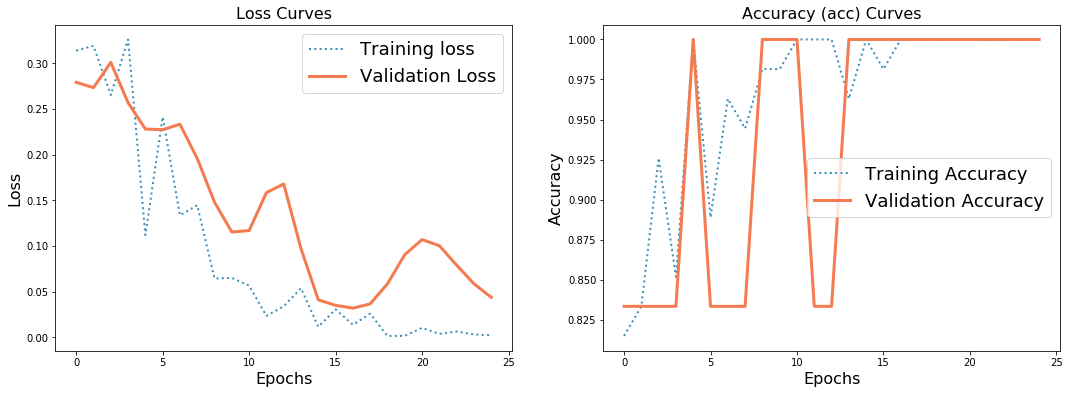

In [89]:
from utils import plot_loss_and_accuracy

score = model.evaluate(X_test, y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

plot_loss_and_accuracy(model_history, 'acc')

We have just created and trained our first deep network model 🎉

Let's try it!

### Predict using our model

We are going to predict individual images, using _test_ images.

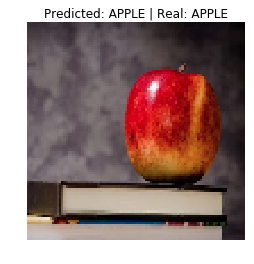

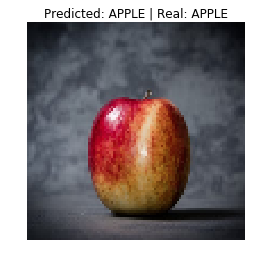

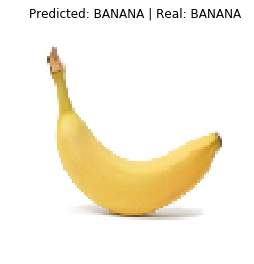

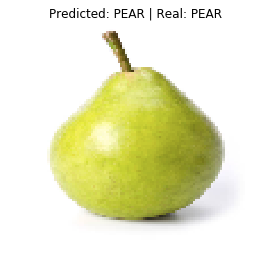

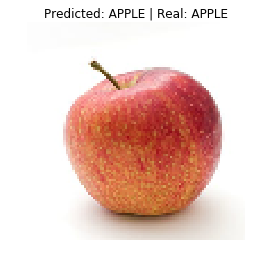

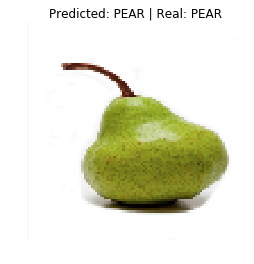

In [90]:
predictions = model.predict(X_test)

#print('The type predicted is: {}'.format(class_names[np.argmax(predictions)]))
for i, pred in enumerate(predictions):
    pred_value = np.argmax(pred)
    real_value = np.argmax(y_test[i])
    img = X_test[i]

    plt.imshow(img)
    
    plt.axis('off')
    plt.title('Predicted: {} | Real: {}'.format(class_names[pred_value], class_names[real_value]))
    plt.show()

## Save your model for future use

You can now export and save your trained model. From now on, you won't need to re-train it. You can just load it and use it for predictions.

In [91]:
model.save('fruit_cnn_model.h5')

## Load Keras model - Using our pre-trained model

Once you've trained a Keras model, you can load it and start predictions without the need of re-training it.

In [92]:
from keras.models import load_model

model = load_model('fruit_cnn_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15488)             0         
__________

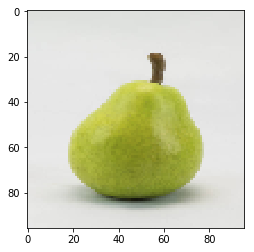

The type predicted is: PEAR


In [93]:
img_pear = preprocessing.image.load_img('./data/pears/3.png',
                                      target_size=(width, height))
plt.imshow(img_pear)
plt.show()

X_pear = np.expand_dims(img_pear, axis=0)

predictions = model.predict(X_pear)

print('The type predicted is: {}'.format(class_names[np.argmax(predictions)]))

---
## Your assignment!

- Search on Google more testing images and predict using our trained model.

In [8]:
# your code goes here...


<img src="https://camo.githubusercontent.com/53f6fb6ccefefd87dc93af20b8e7972573de9828/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f373036353430312f33393131393531382d35396661353163652d343665632d313165382d383530332d3566383133363535386632622e706e67">

<a href="https://rmotr.com" target="_blank"><img src="https://camo.githubusercontent.com/cc5541fa8bc6f822cb8d5b4261a23f20ec8321f4/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f373036353430312f33393131393438362d34373138653338362d343665632d313165382d396663332d3532353061343965663537302e706e67">
</a>